# PyTorch CNN Tutorial - SCR

First of all import all packages needed in this problem.

In [2]:
import torch
import numpy as np
# import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,recall_score)
from torchvision.transforms import ToTensor, Resize, Lambda, RandomHorizontalFlip
from collections import Counter

## Load CIFAR10 dataset:

In the first step, load CIFAR10 with torchvision and split it to train, valid and test data. Also in this step, convert each label to onehot vector with lambda function.

At the end, visualize one sample of each class in CIFAR10 dataset randomly.

Using cuda device


Files already downloaded and verified
Files already downloaded and verified




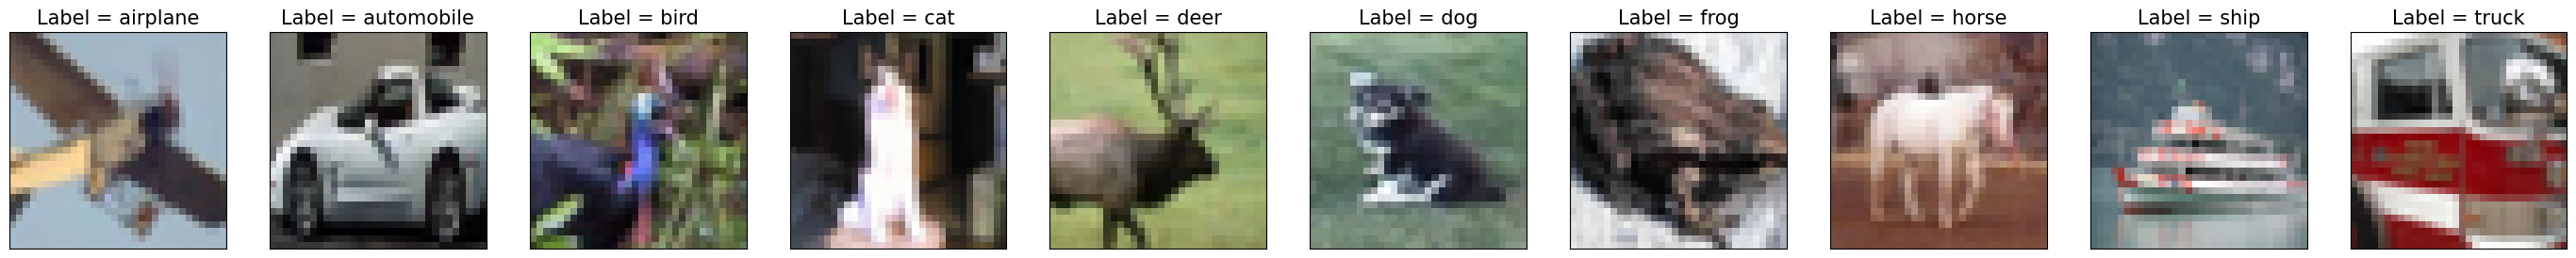

In [3]:
# number of mini-batch size:
Batch_size=32

# Define input image size
img_size=(32,32,3)

# Selecting the appropriate training device:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device\n\n")

# Define a train and test Transform to resize image and convert to tensor:
train_transforms = torchvision.transforms.transforms.Compose(
        [Resize([32, 32]),
         RandomHorizontalFlip(),
         ToTensor()])

test_transforms = torchvision.transforms.transforms.Compose(
        [Resize([32, 32]),
         ToTensor()])
# load Cifar10 dataset with torchvision: (Use lambda to convert each label to onehot vector)
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transforms, download=True,
                                       target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)))

# Split dataset to train_set and validation_set (85%-15%):
train_size = int(0.85 * len(dataset.data))
valid_size = len(dataset.data) - train_size
train_set, val_set = random_split(dataset, [train_size, valid_size])

# Use Dataloader to ordination train_set and validation_set according to it's mini-batch size:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=Batch_size, shuffle=True )
validate_loader = torch.utils.data.DataLoader(val_set, batch_size=Batch_size, shuffle=True)

# load Cifar10 Test dataset with torchvision and load them with dataloader:
Test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transforms, download=True,
                                            target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)))
test_loader = torch.utils.data.DataLoader(Test_dataset,batch_size=Batch_size, shuffle=True)

# define a convert function to convert each onehot vector to specific label of that class.
def convert(vector):
     label=torch.where(vector==1)[0].item()
     Classes= {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'} 
     return Classes[label]
print("\n")

# Divide data according to the their classes(separate each class and their data):
sample_Indexs=[]
for i in range(10) :sample_Indexs.append([] )
for num in range(0,len(dataset.targets)):
    sample_Indexs[dataset.targets[num]].append(num)

# select a random data of each class and plot it with it's label.
fig=plt.figure(figsize=(35,25),facecolor='w')
for i in range(10):
     rand_num= np.random.randint(1,50,1).item()
     img, label = dataset[sample_Indexs[i][rand_num]]
     ax = plt.subplot(1,10, i+1)
     plt.imshow(img.permute(1,2,0))
     ax.set_title(f"Label = {convert(label)}", fontsize=15)
     ax.get_xaxis().set_visible(False)
     ax.get_yaxis().set_visible(False)

## Implementation of a CNN based Image Classifier from Scratch:

First of all, Define a train and test loop for our training.

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (img, y) in enumerate(dataloader):
        img=img.to(device)
        y=y.to(device)
        # Compute prediction and loss
        pred = model(img)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(img)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, correct = 0, 0

    with torch.no_grad():
        for img, y in dataloader:
            img=img.to(device)
            y=y.to(device)
            pred = model(img)
            valid_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    valid_loss /= num_batches
    correct /= size
    print(f"Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")

### Secondly, Define a CNN model:

According to the Torch API we have: [Source](https://pytorch.org/docs/stable/nn.html)

- torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

- torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

- torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)

- torch.nn.Dropout2d(p=0.5, inplace=False)

In [5]:
# Creating the model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            #Input = 3 x 32 x 32, Output = 32 x 32 x 32
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 'same'), 
            nn.ReLU(),
            nn.Dropout2d(0.05),
            #Input = 32 x 32 x 32, Output = 32 x 16 x 16
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32),
  
            #Input = 32 x 16 x 16, Output = 64 x 16 x 16
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            #Input = 64 x 16 x 16, Output = 64 x 8 x 8
            nn.MaxPool2d(kernel_size=2),
              
            #Input = 64 x 8 x 8, Output = 64 x 8 x 8
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #Input = 64 x 8 x 8, Output = 64 x 4 x 4
            nn.MaxPool2d(kernel_size=2),
  
            nn.Flatten(),
            nn.BatchNorm1d(64*4*4),
            nn.Linear(64*4*4, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
  

    def forward(self, x):
        x = self.model(x)
        x = F.softmax(x, dim=1)
        return x

In [6]:
CNN_model = ConvNet().to(device)

for param in CNN_model.parameters():
    param.requires_grad = True
CNN_model.train()    
print("Network Architecture:")
print(CNN_model)

Network Architecture:
ConvNet(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Dropout2d(p=0.05, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Linear(in_features=1024, out_features=128, bias=True)
   

In [7]:
# Defining the model hyper parameters:
lr = 2e-4
epochs = 5
weight_decay = 0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, CNN_model.parameters()), lr=lr,  weight_decay = weight_decay)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, CNN_model, loss_fn, optimizer)
    test_loop(validate_loader, CNN_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302272  [    0/42500]
loss: 2.219692  [ 3200/42500]
loss: 2.149276  [ 6400/42500]
loss: 2.187615  [ 9600/42500]
loss: 2.091666  [12800/42500]
loss: 2.019790  [16000/42500]
loss: 2.123006  [19200/42500]
loss: 2.125691  [22400/42500]
loss: 2.040968  [25600/42500]
loss: 2.073212  [28800/42500]
loss: 2.027201  [32000/42500]
loss: 2.023804  [35200/42500]
loss: 2.117084  [38400/42500]
loss: 1.960984  [41600/42500]
Error: 
 Accuracy: 45.8%, Avg loss: 2.016824 

Epoch 2
-------------------------------
loss: 2.111652  [    0/42500]
loss: 1.910316  [ 3200/42500]
loss: 2.048353  [ 6400/42500]
loss: 2.028718  [ 9600/42500]
loss: 2.021635  [12800/42500]
loss: 2.013133  [16000/42500]
loss: 2.057028  [19200/42500]
loss: 2.031589  [22400/42500]
loss: 1.955248  [25600/42500]
loss: 1.870217  [28800/42500]
loss: 1.897251  [32000/42500]
loss: 1.944971  [35200/42500]
loss: 1.867519  [38400/42500]
loss: 1.865793  [41600/42500]
Error: 
 Accuracy: 50.8%, Avg los

### Evaluation:

In [8]:
CNN_model.eval()
loss_fn_eval = nn.CrossEntropyLoss()
# CNN evaluation
print("Evaluation results for train data:")
test_loop(train_loader, CNN_model, loss_fn_eval)
print("Evaluation results for validate data:")
test_loop(validate_loader, CNN_model, loss_fn_eval)
print("Evaluation results for test data:")
test_loop(test_loader, CNN_model, loss_fn_eval)

Evaluation results for train data:
Error: 
 Accuracy: 55.8%, Avg loss: 1.955975 

Evaluation results for validate data:
Error: 
 Accuracy: 53.7%, Avg loss: 1.970314 

Evaluation results for test data:
Error: 
 Accuracy: 54.8%, Avg loss: 1.964239 



In [9]:
Cifar10_classes = ('airplane','automobile','bird','cat',
                   'deer','dog','frog','horse','ship','truck')
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in Cifar10_classes}
total_pred = {classname: 0 for classname in Cifar10_classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        img, y = data
        img=img.to(device)
        y=y.to(device)
        labels = y.argmax(1)
        pred = CNN_model(img)
        predictions = pred.argmax(1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[Cifar10_classes[label]] += 1
            total_pred[Cifar10_classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 74.7 %
Accuracy for class: automobile is 75.9 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 61.8 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 88.8 %
Accuracy for class: horse is 80.7 %
Accuracy for class: ship  is 82.5 %
Accuracy for class: truck is 83.6 %


## Transfer Learning:

We can use PyTorch for loading pre-trained model, Also we can use Timm ([Medium](https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055)) library to load a variety of pre-trained models trained on diferent datasets.(PyTorch image models: [github](https://github.com/huggingface/pytorch-image-models))

In [10]:
# Define input image size
img_size=(224,224,3)

# Define a train and test Transform to resize image and convert to tensor:
train_transforms = torchvision.transforms.transforms.Compose(
        [Resize([224, 224]),
         RandomHorizontalFlip(),
         ToTensor()])

test_transforms = torchvision.transforms.transforms.Compose(
        [Resize([224, 224]),
         ToTensor()])
# load Cifar10 dataset with torchvision: (Use lambda to convert each label to onehot vector)
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transforms, download=True,
                                       target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)))

# Split dataset to train_set and validation_set (85%-15%):
train_size = int(0.85 * len(dataset.data))
valid_size = len(dataset.data) - train_size
train_set, val_set = random_split(dataset, [train_size, valid_size])

# Use Dataloader to ordination train_set and validation_set according to it's mini-batch size:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=Batch_size, shuffle=True )
validate_loader = torch.utils.data.DataLoader(val_set, batch_size=Batch_size, shuffle=True)

# load Cifar10 Test dataset with torchvision and load them with dataloader:
Test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transforms, download=True,
                                            target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)))
test_loader = torch.utils.data.DataLoader(Test_dataset,batch_size=Batch_size, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Load pre-trained ResNet50 on imageNet
based_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)
# Freeze all parameters    
for param in based_model.parameters():
    param.requires_grad = False   
# Modified FC layers
based_model.fc = nn.Sequential(
               nn.BatchNorm1d(based_model.fc.in_features),
               nn.Linear(based_model.fc.in_features, 128),
               nn.ReLU(),
               nn.Dropout(0.25),
               nn.Linear(128, 10),
               nn.Softmax(dim=1)).to(device)
# Set all parameters in FC layer requires grad to update it's weights.
for param in based_model.fc.parameters():
    param.requires_grad = True

### Train the Fully Connected layers

In [12]:
# Defining the model hyper parameters:
lr = 1e-4
epochs = 2
weight_decay = 0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, based_model.parameters()), lr=lr, weight_decay = weight_decay)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, based_model, loss_fn, optimizer)
    test_loop(validate_loader, based_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304326  [    0/42500]
loss: 2.042099  [ 3200/42500]
loss: 1.832334  [ 6400/42500]
loss: 1.895695  [ 9600/42500]
loss: 1.841786  [12800/42500]
loss: 1.794591  [16000/42500]
loss: 1.678760  [19200/42500]
loss: 1.785957  [22400/42500]
loss: 1.831340  [25600/42500]
loss: 1.788245  [28800/42500]
loss: 1.747087  [32000/42500]
loss: 1.806434  [35200/42500]
loss: 1.766329  [38400/42500]
loss: 1.779386  [41600/42500]
Error: 
 Accuracy: 79.7%, Avg loss: 1.714312 

Epoch 2
-------------------------------
loss: 1.745071  [    0/42500]
loss: 1.619226  [ 3200/42500]
loss: 1.729790  [ 6400/42500]
loss: 1.778083  [ 9600/42500]
loss: 1.761370  [12800/42500]
loss: 1.755188  [16000/42500]
loss: 1.824540  [19200/42500]
loss: 1.704269  [22400/42500]
loss: 1.784478  [25600/42500]
loss: 1.724730  [28800/42500]
loss: 1.751894  [32000/42500]
loss: 1.666143  [35200/42500]
loss: 1.673313  [38400/42500]
loss: 1.701102  [41600/42500]
Error: 
 Accuracy: 80.1%, Avg los

### Evaluating:

In [12]:
# compute model accuracy and Ave loss on train, valid and test data.
based_model.eval()
# Define cross entropy loss function
loss_fn_eval = nn.CrossEntropyLoss()
# based_model evaluation
print("Evaluation results for train data:")
test_loop(train_loader, based_model, loss_fn_eval)
print("Evaluation results for validate data:")
test_loop(validate_loader, based_model, loss_fn_eval)
print("Evaluation results for test data:")
test_loop(test_loader, based_model, loss_fn_eval)

Evaluation results for train data:
Error: 
 Accuracy: 80.2%, Avg loss: 1.707139 

Evaluation results for validate data:
Error: 
 Accuracy: 80.1%, Avg loss: 1.711155 

Evaluation results for test data:
Error: 
 Accuracy: 79.4%, Avg loss: 1.713852 



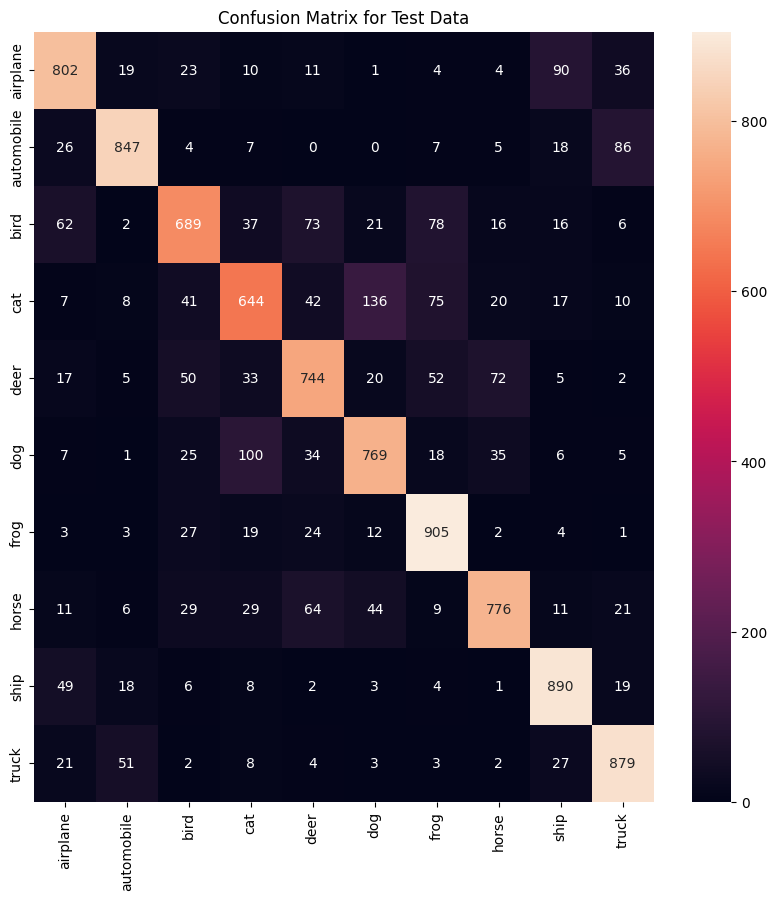




Test Accuracy: 79.45 %
Test Precision: 79.38 %
Test Recall: 79.45 %


In [13]:
# Confusion Matrix for Test Data
preds_test = torch.zeros(len(Test_dataset))
true_label = torch.zeros(len(Test_dataset))
for i in range(len(Test_dataset)):
    true_label[i] = Test_dataset[i][1].to(device).argmax()
    with torch.no_grad():
        preds_test[i] = based_model((Test_dataset[i][0][None,...]).to(device)).argmax()


test_acc = accuracy_score(true_label.numpy(), preds_test.numpy())
test_prc = precision_score(true_label.numpy(), preds_test.numpy(), average='macro')
test_rcl = recall_score(true_label.numpy(), preds_test.numpy(), average='macro')
test_cf = confusion_matrix(true_label.numpy(), preds_test.numpy())


plt.figure(figsize=(10, 10))
sns.heatmap(test_cf, xticklabels=Cifar10_classes, yticklabels=Cifar10_classes, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Test Data')
plt.show()
print("\n\n")
print(f"Test Accuracy: {test_acc*100:.2f} %")
print(f"Test Precision: {test_prc*100:.2f} %")
print(f"Test Recall: {test_rcl*100:.2f} %")

## Training a model without transfer learning:

In [ ]:
# Load just ResNet18 model without any pre-trained weights:
resnet18_model = models.resnet18(weights=None).to(device)
# Modified FC layers
resnet18_model.fc = nn.Sequential(
               nn.BatchNorm1d(resnet18_model.fc.in_features),
               nn.Linear(resnet18_model.fc.in_features, 10),
               nn.Softmax(dim=1)).to(device)
# Set all parameters in resnet18 requires grad to update it's weights.
for param in resnet18_model.parameters():
    param.requires_grad = True

In [ ]:
# Defining the model hyper parameters:
lr = 2e-4
epochs = 2

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, resnet18_model.parameters()), lr=lr)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, resnet18_model, loss_fn, optimizer)
    test_loop(validate_loader, resnet18_model, loss_fn)
print("Done!")

In [ ]:
# compute model accuracy and Ave loss on train, valid and test data.
resnet18_model.eval()
# Define cross entropy loss function
loss_fn_eval = nn.CrossEntropyLoss()
# resnet18_model evaluation
print("Evaluation results for train data:")
test_loop(train_loader, resnet18_model, loss_fn_eval)
print("Evaluation results for validate data:")
test_loop(validate_loader, resnet18_model, loss_fn_eval)
print("Evaluation results for test data:")
test_loop(test_loader, resnet18_model, loss_fn_eval)

## Knowledge Distillation: [Source](https://intellabs.github.io/distiller/knowledge_distillation.html)


 Sometiems it is not efficient to utilize high parameter networks for minor applications moreover, the small networks might not be as powerfull as the bigger ones so one way to increase the accuracy of the model is to use a technique called knowledge distillation. Training the resnet18 model according to the **Knowledge Distillation** from a teacher (resnet50):


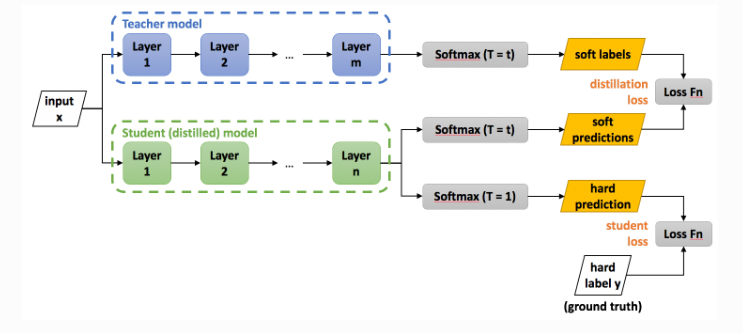

In distillation, knowledge is transferred from the teacher model to the student by minimizing a loss function in which the target is the distribution of class probabilities predicted by the teacher model. That is - the output of a softmax function on the teacher model's logits. However, in many cases, this probability distribution has the correct class at a very high probability, with all other class probabilities very close to 0. As such, it doesn't provide much information beyond the ground truth labels already provided in the dataset. To tackle this issue, [Hinton et al](Geoffrey Hinton, Oriol Vinyals and Jeff Dean. Distilling the Knowledge in a Neural Network. arxiv:1503.02531)., 2015 introduced the concept of "softmax temperature". The probability pi
 of class i
 is calculated from the logits z
 as:

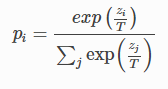

The overall loss function, incorporating both distillation and student losses, is calculated as:

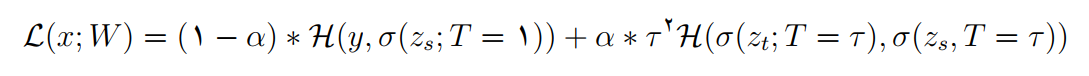

In [ ]:
# calculate softmax temperature
def softmax_temperature(Z, Temp=2):
    return torch.exp(Z/Temp)/(torch.unsqueeze(torch.sum(torch.exp(Z/Temp),dim=1),1))

# # calculate cross entropy
def cross_entropy(y_true,y_pred):
    y_true=y_true.to(device)
    y_pred=y_pred.to(device)
    N_batch=len(y_true)
    return -((y_true* torch.log(y_pred)).sum() /N_batch)

# Calculate distiller_loss 
def distiller_loss(Z_t, Z_s, y_true, Temp=2, alpha=0.1):
    return (1-alpha)*cross_entropy(y_true,softmax_temperature(Z_s, Temp=1))+ alpha*(Temp**2)*cross_entropy(softmax_temperature(Z_t, Temp=Temp),softmax_temperature(Z_s, Temp=Temp))

In [ ]:
def teacher_train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (img, y) in enumerate(dataloader):
        img=img.to(device)
        y=y.to(device)
        # Compute prediction and loss
        pred = model(img)
        pred= softmax_temperature(pred, Temp=2)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(img)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def teachear_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, correct = 0, 0

    with torch.no_grad():
        for img, y in dataloader:
            img=img.to(device)
            y=y.to(device)
            pred = model(img)
            pred= softmax_temperature(pred, Temp=2)
            valid_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    valid_loss /= num_batches
    correct /= size
    print(f"Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")

Teacher Model

In [ ]:
# Load pre-trained ResNet50 on imageNet
teacher_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)
# Freeze all parameters    
for param in teacher_model.parameters():
    param.requires_grad = False   
# Modified FC layers
teacher_model.fc = nn.Sequential(
               nn.BatchNorm1d(teacher_model.fc.in_features),
               nn.Linear(teacher_model.fc.in_features, 10)).to(device)
# Set all parameters in FC layer requires grad to update it's weights.
for param in teacher_model.fc.parameters():
    param.requires_grad = True

Student Model

In [ ]:
# Load pre-trained ResNet18 on imageNet
student_model = models.resnet18(weights=None).to(device)
# Modified FC layers
student_model.fc = nn.Sequential(
               nn.BatchNorm1d(student_model.fc.in_features),
               nn.Linear(student_model.fc.in_features, 10)).to(device)
# Set all parameters in resnet18 requires grad to update it's weights.
for param in student_model.parameters():
    param.requires_grad = True

In [ ]:
# Defining the model hyper parameters:
lr = 1e-4
epochs = 5
weight_decay = 0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, teacher_model.parameters()), lr=lr, weight_decay = weight_decay)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    teacher_train_loop(train_loader, teacher_model, loss_fn, optimizer)
    teachear_test_loop(validate_loader, teacher_model, loss_fn)
print("Done!")

In [ ]:
def distiller_training_loop(train_loader, validate_loader, test_loader, teacher_model, student_model, epoch=5, Temp=2, alpha=0.25):
    teacher_model.eval()
    student_model.train()
    size_train = len(train_loader.dataset)
    size_valid = len(validate_loader.dataset)
    num_batches_valid = len(validate_loader)
    size_test = len(test_loader.dataset)
    num_batches_test = len(test_loader)

    # Set adam optimizer to train student model
    optimizer_st = torch.optim.Adam(filter(lambda param: param.requires_grad, student_model.parameters()), lr=1e-4)

    # training and validating process 
    val_acc=[]
    val_loss=[]
    for Epoch in range(epoch):
        print(f"Epoch {Epoch+1}\n-------------------------------")
        # compute distiller-loss over epoch and update student model weights
        for batch, (X, y) in enumerate(train_loader):
            X=X.to(device)
            y=y.to(device)
            # Compute logits of teacher and student model  
            Z_t = teacher_model(X)
            Z_s = student_model(X)

            loss = distiller_loss(Z_t, Z_s, y_true=y, Temp=Temp, alpha=alpha)

            # Backpropagation
            optimizer_st.zero_grad()
            loss.backward()
            optimizer_st.step()

            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size_train:>5d}]")

        # validation:
        loss_fn = nn.CrossEntropyLoss()
        valid_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in validate_loader:
                X=X.to(device)
                y=y.to(device)
                pred_st = student_model(X)
                pred_st =  softmax_temperature(pred_st, Temp=Temp)
                valid_loss += loss_fn(pred_st, y).item()
                correct += (pred_st.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

        valid_loss /= num_batches_valid
        correct /= size_valid
        print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")
        val_acc.append(100*correct)
        val_loss.append(valid_loss)


    # Testing process:
    te_acc=[]
    te_loss=[]
    # test:
    loss_fn = nn.CrossEntropyLoss()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_loader:
            X=X.to(device)
            y=y.to(device)
            pred_st = student_model(X)
            pred_st =  softmax_temperature(pred_st, Temp=Temp)
            test_loss += loss_fn(pred_st, y).item()
            correct += (pred_st.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches_test
    correct /= size_test
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    te_acc=100*correct
    te_loss=test_loss

    return val_acc,val_loss,te_acc,te_loss

In [ ]:
# trainig of student model according to knowledge distillation from a teacher with best hyperparameters:
training = distiller_training_loop(train_loader, validate_loader, test_loader,teacher_model= teacher_model, student_model=student_model, epoch=5, Temp=2, alpha=0.25)

In [ ]:
# compute model accuracy and Ave loss on train, valid and test data.
student_model.eval()
# Define cross entropy loss function
loss_fn_eval = nn.CrossEntropyLoss()
# student_model evaluation
print("Evaluation results for train data:")
teachear_test_loop(train_loader, student_model, loss_fn_eval)
print("Evaluation results for validate data:")
teachear_test_loop(validate_loader, student_model, loss_fn_eval)
print("Evaluation results for test data:")
teachear_test_loop(test_loader, student_model, loss_fn_eval)